# LLM Model Customization with Superwise:

### Fine Tuning LoRA adaptors and deploying them to **Superwise®**!

Low Rank Adaptation (LoRA) is a technique used to efficiently fine-tune large pre-trained models by introducing low-rank matrices into the model's architecture. This approach reduces the number of trainable parameters, making the fine-tuning process more computationally efficient and less resource-intensive. In this tutorial, we will build a custom Quantized LoRA (QLoRA) adaptor and deploy it to Superwise.

## **1. Getting started**
We will start by installing the required libraries.

In [ ]:
!pip install datasets pandas transformers scikit-learn trl superwise-api bitsandbytes accelerate torch peft --quiet

After that, we will import all of the required modules.

In [ ]:
import pandas as pd
import torch
import requests
from datasets import load_dataset
from sklearn.metrics import accuracy_score
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    pipeline,
    TrainingArguments,
    BitsAndBytesConfig,
)
from trl import (
    SFTTrainer,
    SFTConfig,
    DataCollatorForCompletionOnlyLM,
)

from superwise_api.superwise_client import SuperwiseClient
from superwise_api.models.application.application import ModelLLM, ModelProvider, \
OpenAICompatibleModel
from peft import LoraConfig

## **2. Quantization Configuration**

Quantization is a technique used to reduce the memory footprint and computational requirements of large language models by representing their weights and activations with lower precision data types, such as 8-bit integers instead of 32-bit floating-point numbers. This process helps in deploying models on resource-constrained environments without significantly compromising their performance. QLoRA works by quantizing the underlying base model, freezing the model parameters, and then adding additional, tuned adaptor layers to the base model.
<br/><br/>

For this model, using 4-bit quantization will allow us to save significantly on memory, while achieving the same performance as a non-quantized model.

In [ ]:
compute_dtype = getattr(torch, "float16")

quant_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=False,
)

## **3. Dataset, model, and tokenizer**

For this model, I will be using the openassistant-guanaco dataset. This dataset contains over 10k rows of Question-Answer pairs for AI assistants. This particular branch was originally used to train the Guanaco model with QLoRA, so the data has been cleaned to only contain the highest-rated paths in the conversation tree.
<br/><br/>

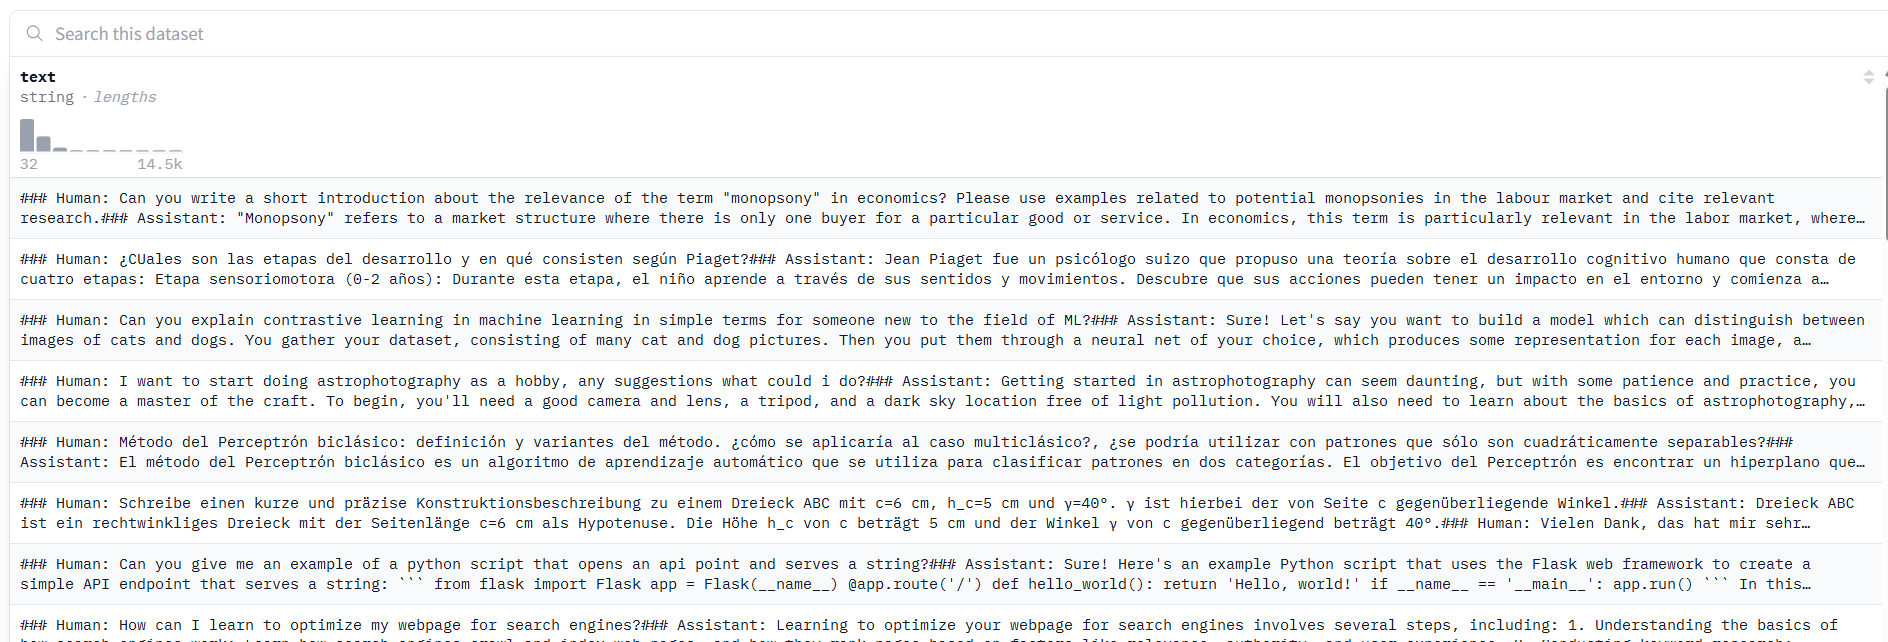

The model chosen is OPT 350m from Meta. Having only 350M weights, it makes for a speedy fine tuning to get a handle on QLoRA. Since we are quantizing this model to save on resources, we need to include our quantization config in the model object.

In [ ]:
dataset = load_dataset("timdettmers/openassistant-guanaco", split="train")

model = AutoModelForCausalLM.from_pretrained("facebook/opt-350m", quantization_config=quant_config,)
tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m")

## **4. Tuning Hyperparameters**

The following hyperparameters are a good starting point for simple tuning jobs.
<br></br>

**output_dir:** The directory is where model predictions and checkpoints will be stored.

**num_train_epochs:** One training epoch to keep the training quick.

**fp16/bf16:** Disable fp16/bf16 training to conserve memory.

**per_device_train_batch_size:** Batch size per GPU for training.

**per_device_eval_batch_size:** Batch size per GPU for evaluation.

**gradient_accumulation_steps:** number of steps required to accumulate the gradients during the update process.

**gradient_checkpointing:** Enabling gradient checkpointing.

**max_grad_norm:** Gradient clipping.

**learning_rate:** Initial learning rate.

**weight_decay:** Weight decay is applied to all layers except bias/LayerNorm weights.

**Optim:** Model optimizer (AdamW optimizer).

**lr_scheduler_type:** Learning rate schedule.

**max_steps:** Number of training steps.

**warmup_ratio:** Ratio of steps for a linear warmup.

**group_by_length:** This can significantly improve performance and accelerate the training process.

**save_steps:** Number of steps between checkpoints.

**logging_steps:** Number of steps between logs.

In [ ]:
training_params = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=1,
    optim="paged_adamw_32bit",
    save_steps=25,
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=False,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=True,
    lr_scheduler_type="constant",
    report_to="tensorboard"
)

In addition to the above hyperparameters, we will be setting hyperparameters for Parameter-Efficient Fine-Tuning (PEFT). Using PEFT allows us to save time and memory during training by only training the most impactful parameters. This makes fine tuning our adapter possible on even modest GPUs.

In [ ]:
peft_params = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.1,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
)

## **5. Training**

Now that we have everything ready, it is time to set up our training run and get training! Here, I am using SFTTrainer from the trl package to set up the Supervised Fine-Tuning (SFT) run with our configured hyperparameters.

In [ ]:
trainer = SFTTrainer(
    model,
    args=training_params,
    train_dataset=dataset,
    peft_config=peft_params,
)

Now it is time to set it running! Depending on your machine specs, this should take between 20-90 minutes (mine took 45 minutes).

In [ ]:
trainer.train()

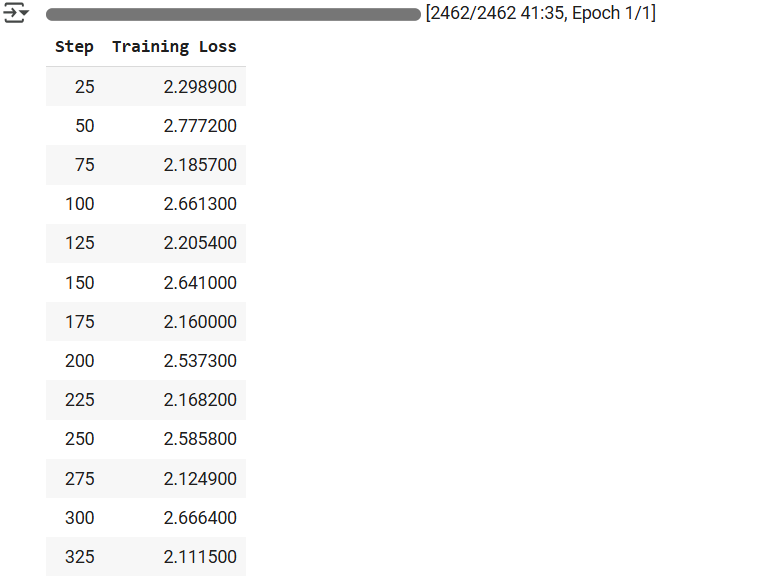


After training, I save the model so that it can be deployed later.

In [ ]:
trainer.model.save_pretrained("new_LoRA_model")
trainer.tokenizer.save_pretrained("new_LoRA_model")

Now with our trained model saved, we can take a look at the evaluation results from the logs we collected in tensorboard.

In [ ]:
from tensorboard import notebook
log_dir = "results/runs"
notebook.start("--logdir {} --port 4000".format(log_dir))

This will start a web ui that displays many different charts to provide hard numbers for how well the model training went.


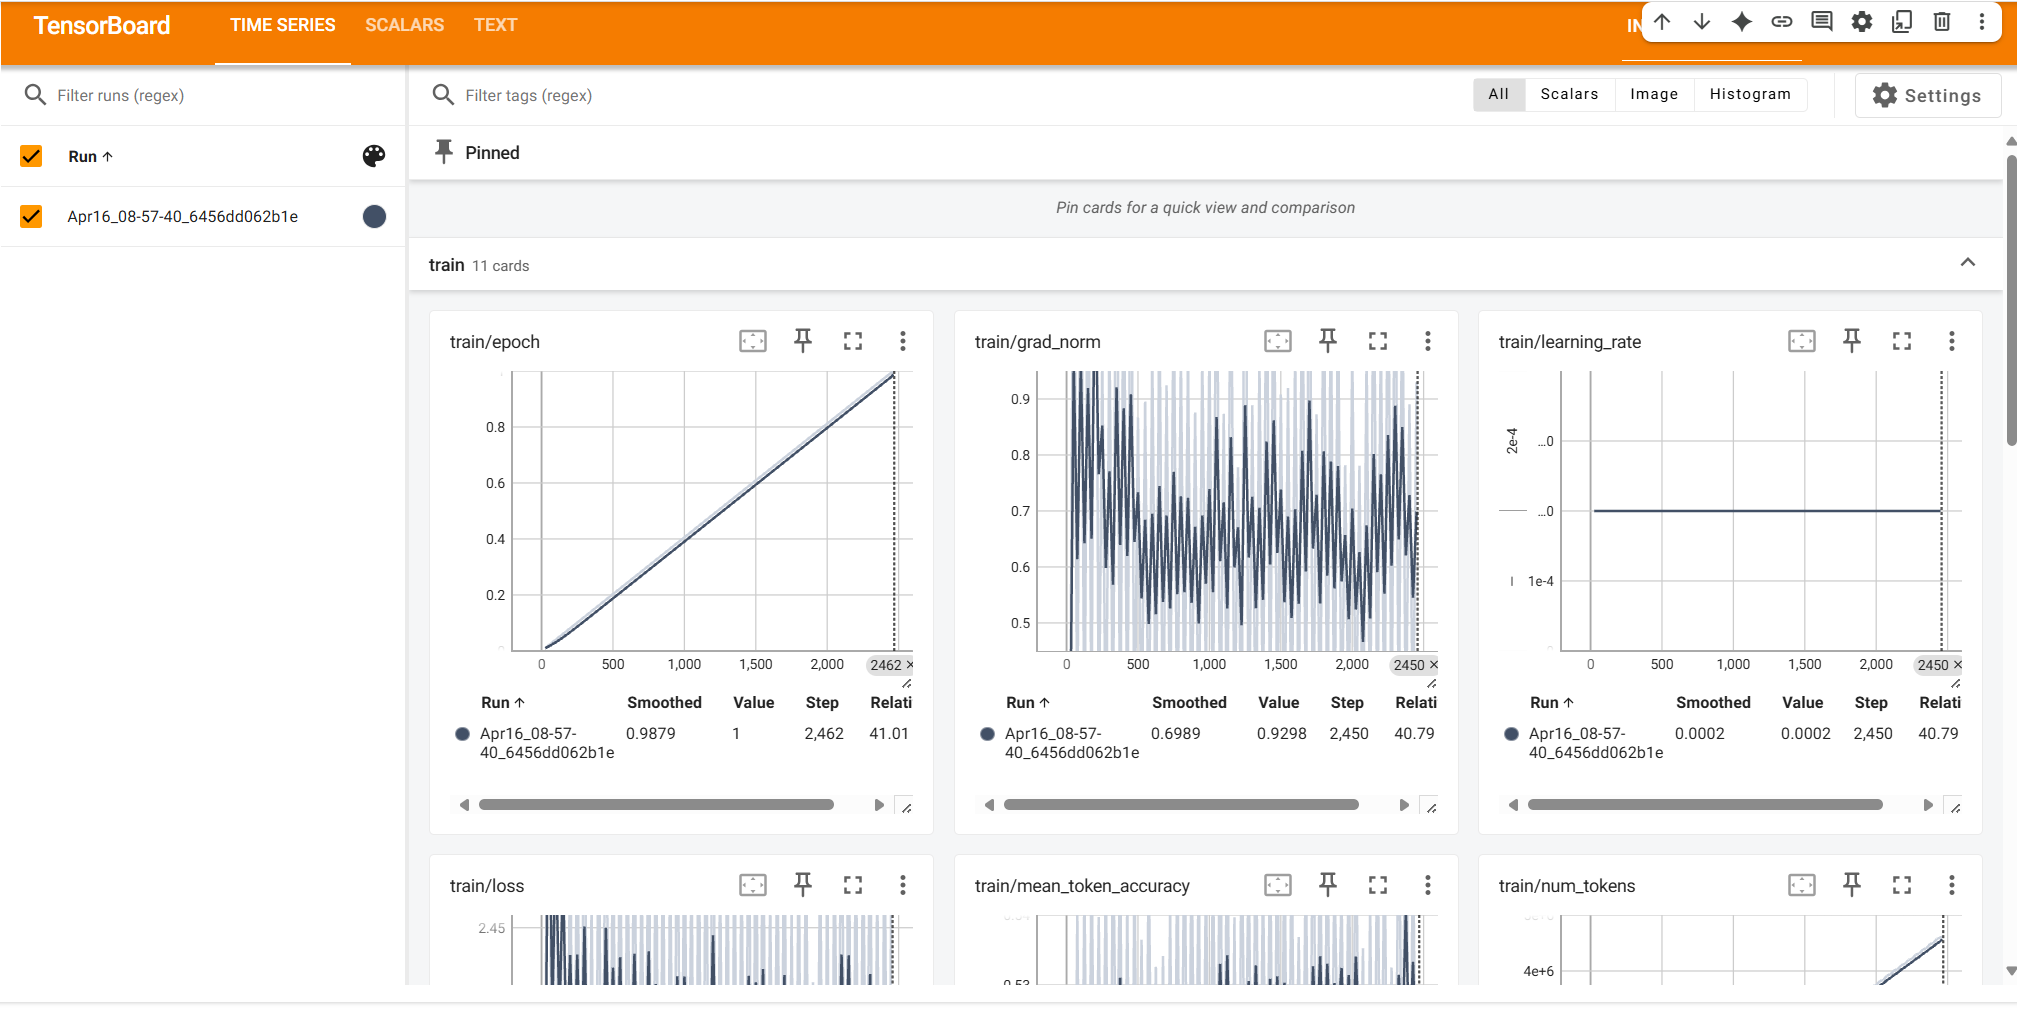

## **6. Deploying to a Superwise Application**

In order to use our new model within a Superwise application, it first needs to be deployed to a cloud endpoint. The Superwise platform is compatible with any provider that uses an OpenAI-compatible api endpoint, so check if the provider you are using conforms to this standard. I prefer to deploy my models using Google Cloud (GCP). The requirements for using a model deployed to a GCP endpoint within a Superwise application can be found [here](https://docs-swe.superwise.ai/docs/gcp-requirements).

Once the model endpoint is deployed through a cloud provider, the endpoint can be access through any Superwise application. A tutorial for how to set a Superwise application up can be found [here](https://docs-swe.superwise.ai/docs/build-a-new-gen-ai-app).

## **7. Superwise App Inference Through the API**

In order to inference the new model through the API, a Superwise Client connection with appropriate client id and client secret are required.

In [ ]:
client_id = ''
client_secret = ''

sw = SuperwiseClient(client_id = client_id, client_secret = client_secret)

After a connection is established with the Superwise Client, the application can be directly accessed using the following function.

In [ ]:
def ask_application_via_api(app_id, app_token, user_input):
  endpoint_url = f"https://api.superwise.ai/v1/app-worker/{app_id}/v1/ask"

  print(app_id)
  print(user_input)
  print(app_token)

  payload = {
    "chat_history": [],
    "input": user_input,
    #"prompt": prompt
  }

  headers = {
    "accept": "application/json",
    "content-type": "application/json",
    "x-api-token": app_token
}

  resp = requests.post(endpoint_url, json=payload, headers=headers)
  app_response = resp.json()
  return app_response

To use this function, the app id and app token are required.

In [ ]:
#get the app id and the app token
app_id = sw.application.get(name="LoRA_Test_App").items[0].id
app_token = str(sw.application.get(name="LoRA_Test_App").items[0].api_token)
print(app_id)
print(app_token)

Now that everything is set up, we are ready to make an inference!

In [ ]:
lora_question = "How would the Future of AI in 10 Years look?"

lora_answer = ask_application_via_api(app_id, app_token, lora_question)
lora_answer["output"]